<br> </br>
<font color='darkred' size = 7.5> <center>  <b> Quantitative strategies on high-frequency data </b> </center> </font>
<font color='darkred' size = 5> <center>  2. Rolling analyses - part 2 </center> </font>
<br>
<font size = 5> <center> prof. Piotr Wójcik </center> </font>
<br> 
<font size = 5> <center>  academic year 2025/2026 </center> </font>

In [30]:
# pip install statsmodels arch scikit-learn pyarrow fastparquet
# SELF : location of this interpreter :
# /Users/shah/Documents/STUDY/HFQuantitative Strategies/.venv/bin/python3

In [4]:
# we load the needed libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.stattools import grangercausalitytests
from arch.unitroot import ADF, PhillipsPerron, KPSS
from sklearn.metrics import confusion_matrix
import warnings
# we ignore deprecation warnings and futurewarnings for cleaner output
warnings.filterwarnings("ignore", category=DeprecationWarning)


warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
# we load a dataset with APPL and META prices and returns
# saved into a pickle file at the end of the last lab

dataUSA_AAPL_META = pd.read_pickle("dataUSA_AAPL_META.pkl")

# there might be a problem if the file was pickled in a different version
# of python or NumPy

In [9]:
# lets try the alternative way of loading the data
file_path = "/Users/shah/Documents/STUDY/HFQuantitative Strategies/LABS/03/dataUSA_AAPL_META.pkl"
dataUSA_AAPL_META = pd.read_pickle(file_path)

In [10]:
# Let's remind what is inside
dataUSA_AAPL_META.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72540 entries, 2025-01-02 09:31:00 to 2025-09-30 16:00:00
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   close_AAPL                      72540 non-null  float64
 1   close_META                      72540 non-null  float64
 2   r_AAPL                          72539 non-null  float64
 3   r_META                          72539 non-null  float64
 4   r_AAPL_rolling_std              72480 non-null  float64
 5   r_AAPL_rolling_std_bt           72480 non-null  float64
 6   r_AAPL_rolling_std_pl           72480 non-null  float64
 7   rolling_std_diff_pandas_bt      72480 non-null  float64
 8   rolling_std_diff_pandas_pl      72480 non-null  float64
 9   rolling_std_diff_bt_pl          72480 non-null  float64
 10  rollcorr120_close_AAPL_META     72421 non-null  float64
 11  rollcorr120_close_AAPL_META_pl  72421 non-null  float64
 1

In [11]:
# we do not need columns with differences any more
# lets remove these that include "_diff_" in their names
dataUSA_AAPL_META = dataUSA_AAPL_META.loc[:, ~dataUSA_AAPL_META.columns.str.contains("_diff_")]

dataUSA_AAPL_META.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72540 entries, 2025-01-02 09:31:00 to 2025-09-30 16:00:00
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   close_AAPL                      72540 non-null  float64
 1   close_META                      72540 non-null  float64
 2   r_AAPL                          72539 non-null  float64
 3   r_META                          72539 non-null  float64
 4   r_AAPL_rolling_std              72480 non-null  float64
 5   r_AAPL_rolling_std_bt           72480 non-null  float64
 6   r_AAPL_rolling_std_pl           72480 non-null  float64
 7   rollcorr120_close_AAPL_META     72421 non-null  float64
 8   rollcorr120_close_AAPL_META_pl  72421 non-null  float64
 9   rollcorr120_diff                72421 non-null  float64
dtypes: float64(10)
memory usage: 6.1 MB


In [12]:
dataUSA_AAPL_META.head()

# IMPORTANT - remember that the first returns are NaN
# which may cause problems in some calculations


,close_AAPL,close_META,r_AAPL,r_META,r_AAPL_rolling_std,r_AAPL_rolling_std_bt,r_AAPL_rolling_std_pl,rollcorr120_close_AAPL_META,rollcorr120_close_AAPL_META_pl,rollcorr120_diff
timestamp,,,,,,,,,,
2025-01-02 09:31:00,247.6023,591.9156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-02 09:32:00,247.0636,591.6660,-21.780366,-4.217707,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-02 09:33:00,246.6845,592.0054,-15.356011,5.734700,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-02 09:34:00,246.2006,589.5491,-19.635414,-41.577490,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-02 09:35:00,245.7567,588.9803,-18.046287,-9.652709,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# lets remove the first row from the dataset
dataUSA_AAPL_META = dataUSA_AAPL_META.iloc[1:, :]

##  Linear regression and quantile regression

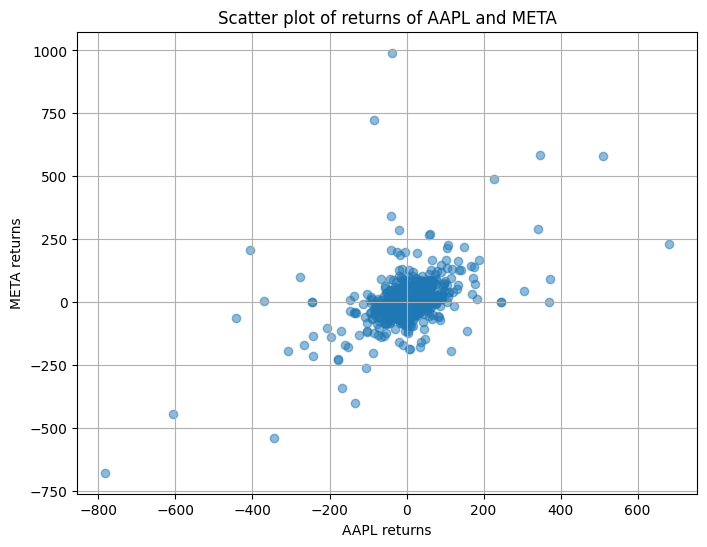

In [14]:
# lets start with a scatter plot of returns of both stocks

plt.figure(figsize=(8,6))
plt.scatter(dataUSA_AAPL_META["r_AAPL"], dataUSA_AAPL_META["r_META"], alpha=0.5)
plt.title("Scatter plot of returns of AAPL and META")
plt.xlabel("AAPL returns")
plt.ylabel("META returns")
plt.grid()
plt.show()

# looks like there is positive relationship between returns of both stocks

In [15]:
# let's quantify it with linear regression

X = dataUSA_AAPL_META["r_AAPL"]
y = dataUSA_AAPL_META["r_META"]
X = sm.add_constant(X)  # adding a constant term for intercept
model_ols = sm.OLS(y, X).fit()
print(model_ols.summary())

# relationship highly significant
# regression coefficient = 0.5366, R2 = 0.221
# constant term not significant

                            OLS Regression Results                            
Dep. Variable:                 r_META   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                 2.063e+04
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        17:41:25   Log-Likelihood:            -2.8049e+05
No. Observations:               72539   AIC:                         5.610e+05
Df Residuals:                   72537   BIC:                         5.610e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0277      0.043      0.645      0.5

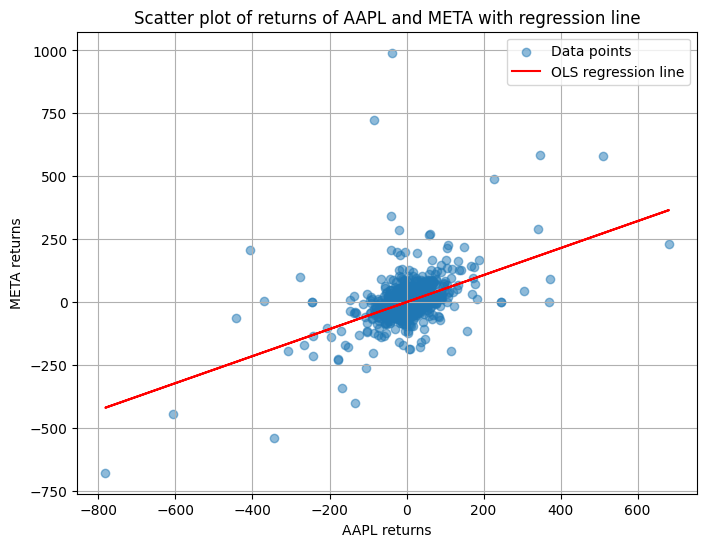

In [16]:
# lets add a regression line to the scatter plot

plt.figure(figsize=(8,6))
plt.scatter(dataUSA_AAPL_META["r_AAPL"], 
            dataUSA_AAPL_META["r_META"], 
            alpha=0.5,
            label="Data points")
# regression line
plt.plot(dataUSA_AAPL_META["r_AAPL"],
         model_ols.predict(X), 
         color='red', label="OLS regression line")
plt.title("Scatter plot of returns of AAPL and META with regression line")
plt.xlabel("AAPL returns")
plt.ylabel("META returns")
plt.legend()
plt.grid()
plt.show()

In [17]:
# how to extract a beta coefficient from the model?
beta_ols = model_ols.params["r_AAPL"]
print("Beta coefficient from OLS regression:", beta_ols)

Beta coefficient from OLS regression: 0.5366496007279348


In [18]:
# lets estimate quantile regression at median (0.5 quantile)
model_qr_median = sm.QuantReg(y, X).fit(q = 0.5)
print(model_qr_median.summary())

# the impact of AAPL returns on conditional median 
# of META returns is statistically significant
# but the slope is a bit smaller (0.4847) than for OLS

                         QuantReg Regression Results                          
Dep. Variable:                 r_META   Pseudo R-squared:              0.08835
Model:                       QuantReg   Bandwidth:                      0.6630
Method:                 Least Squares   Sparsity:                        13.30
Date:                Tue, 28 Oct 2025   No. Observations:                72539
Time:                        17:41:32   Df Residuals:                    72537
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0341      0.025     -1.380      0.168      -0.082       0.014
r_AAPL         0.4878      0.002    227.016      0.000       0.484       0.492


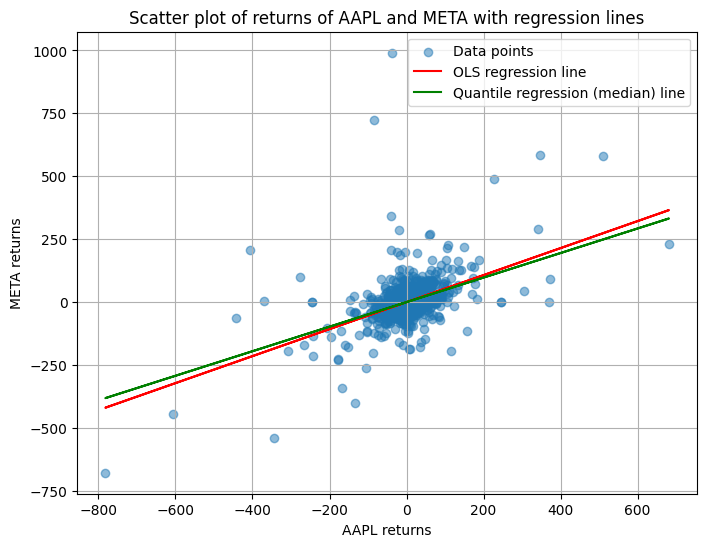

In [19]:
# repeat scatter plot with both OLS and quantile regression lines
plt.figure(figsize=(8,6))
plt.scatter(dataUSA_AAPL_META["r_AAPL"],
            dataUSA_AAPL_META["r_META"], 
            alpha=0.5,
            label="Data points")
# OLS regression line
plt.plot(dataUSA_AAPL_META["r_AAPL"],
         model_ols.predict(X), 
         color='red', label="OLS regression line")
# quantile regression line
plt.plot(dataUSA_AAPL_META["r_AAPL"],
         model_qr_median.predict(X), 
         color='green', label="Quantile regression (median) line")
plt.title("Scatter plot of returns of AAPL and META with regression lines")
plt.xlabel("AAPL returns")
plt.ylabel("META returns")
plt.legend()
plt.grid()
plt.show()

## Testing for cointegration

In [20]:
# lets apply the Engle-Granger two-step method

# Step 1: estimate the long-run relationship with OLS
X_price = dataUSA_AAPL_META["close_AAPL"]
y_price = dataUSA_AAPL_META["close_META"]
X_price = sm.add_constant(X_price)  # adding a constant term for intercept

model_ols_price = sm.OLS(y_price, X_price).fit()
print(model_ols_price.summary())


                            OLS Regression Results                            
Dep. Variable:             close_META   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                 1.618e+04
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        17:41:36   Log-Likelihood:            -4.0908e+05
No. Observations:               72539   AIC:                         8.182e+05
Df Residuals:                   72537   BIC:                         8.182e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        259.3571      3.236     80.150      0.0

In [21]:
# Step 2: obtain the residuals from the OLS regression
residuals = model_ols_price.resid

### ADF test

In [22]:
# and test them for stationarity with the ADF test
adf_test = ADF(residuals)
# by default number of lags is selected automatically based on AIC
# WHICH is not correct as it does not take into account potential autocorrelation
# and trend = 'c' (constant/drift) is used
print(adf_test.summary().as_text())

# We cannot reject H0 about NON-stationarity

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.997
P-value                         0.288
Lags                               22
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [23]:
# lets use simpler settings to speed up the calculations

adf_test2 = ADF(residuals,
                lags = 5, # how many augmentations
                # random walk with a constant/drift - default
                # (alternative: 'n', 'ct', 'ctt' - last with quadratic trend also)
                trend = 'c') 
# More details about the stationarity tests from the arch library:
# https://arch.readthedocs.io/en/latest/unitroot/unitroot_examples.html

print(adf_test2.summary().as_text())

# seems to be much faster - conclusion on cointegration is same as above

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.071
P-value                         0.256
Lags                                5
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


### Philipps-Perron test

In [24]:
# lets apply a Phillips-Perron test

pp_test = PhillipsPerron(residuals) 
# by default lags is set automatically to 12 * (nobs/100) ** (1/4)
# and trend = 'c' (constant/drift) is used

print(pp_test.summary().as_text())
# same conclusion and in ADF test:
# we cannot reject H0 about NON-stationarity

# (also the test statistic and its p-value are 
# very close to that from ADF test)

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -2.062
P-value                         0.260
Lags                               63
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


### KPSS test

In [25]:
# and in the end the KPSS test

kpss_test = KPSS(residuals) 
# by default the number of lags is calculated with
# the data-dependent method of Hobijn et al. (1998) 
# and trend = 'c' (constant/drift) is used

print(kpss_test.summary().as_text())
# same conclusion as in two earlier tests:
# we reject H0 about stationarity!!!

    KPSS Stationarity Test Results   
Test Statistic                 27.596
P-value                         0.000
Lags                              161
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


In [26]:
# How to extract p-values from the tests?

print("p-value from ADF test:", adf_test2.pvalue)
print("p-value from Phillips-Perron test:", pp_test.pvalue)
print("p-value from KPSS test:", kpss_test.pvalue)

p-value from ADF test: 0.25614448340472046
p-value from Phillips-Perron test: 0.26021259321778323
p-value from KPSS test: 0.0001


In [27]:
# lets summarize the above in functions
# that would perform Engle-Granger residual tests
# for any two columns in a given DataFrame

# the function to get residuals from OLS regression
def _eg_residuals(df: pd.DataFrame, col1: str, col2: str):
    X = sm.add_constant(df[col1].values, has_constant="add")
    y = df[col2].values
    model = sm.OLS(y, X).fit()
    return model.resid

# the function for ADF p-value
def eg_adf_pvalue(df: pd.DataFrame, col1: str, col2: str, 
                  trend: str = "c", adf_lags: int = 5) -> float:
    resid = _eg_residuals(df, col1, col2)
    return float(ADF(resid, lags=adf_lags, trend=trend).pvalue)

# the function for PP p-value
def eg_pp_pvalue(df: pd.DataFrame, col1: str, col2: str, 
                 trend: str = "c") -> float:
    resid = _eg_residuals(df, col1, col2)
    return float(PhillipsPerron(resid, trend=trend).pvalue)

# the function for KPSS p-value
def eg_kpss_pvalue(df: pd.DataFrame, col1: str, col2: str, 
                   trend: str = "c") -> float:
    resid = _eg_residuals(df, col1, col2)
    return float(KPSS(resid, trend=trend).pvalue)

In [28]:
# and test them on AAPL and META prices

df_A_M = dataUSA_AAPL_META[["close_AAPL", "close_META"]]
pvalues = (eg_adf_pvalue(df_A_M, "close_AAPL", "close_META"),
           eg_pp_pvalue(df_A_M, "close_AAPL", "close_META"),
           eg_kpss_pvalue(df_A_M, "close_AAPL", "close_META"))

print("p-values from Engle-Granger residual tests (ADF, PP, KPSS):", pvalues)

# looks like results are the same as above 

p-values from Engle-Granger residual tests (ADF, PP, KPSS): (0.25614448340472046, 0.26021259321778323, 0.0001)


### Granger causality test


In [29]:
print("We check if META prices Granger-cause AAPL prices")
# second column is the causing variable
granger_test = grangercausalitytests(dataUSA_AAPL_META[["close_AAPL", "close_META"]], 
                      # if we put maxlag = [10],
                      # we test only for lag = 10
                      maxlag = [10])
print("\n")
print("We check if APPL prices Granger-cause META prices")
granger_test = grangercausalitytests(dataUSA_AAPL_META[["close_META", "close_AAPL"]], 
                      maxlag = [10])

# with 10 minute horizon we have bidirectional Granger causality
# (the null hypothesis of no causality is rejected at any significance level)

We check if META prices Granger-cause AAPL prices

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=6.5379  , p=0.0000  , df_denom=72508, df_num=10
ssr based chi2 test:   chi2=65.3977 , p=0.0000  , df=10
likelihood ratio test: chi2=65.3682 , p=0.0000  , df=10
parameter F test:         F=6.5379  , p=0.0000  , df_denom=72508, df_num=10


We check if APPL prices Granger-cause META prices

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.4940  , p=0.0001  , df_denom=72508, df_num=10
ssr based chi2 test:   chi2=34.9504 , p=0.0001  , df=10
likelihood ratio test: chi2=34.9419 , p=0.0001  , df=10
parameter F test:         F=3.4940  , p=0.0001  , df_denom=72508, df_num=10


In [ ]:
# how to extract F-statistic and its p-value from 
# the Granger causality test result?

# granger_test is a dictionary, where each key is a lag number.
granger_test.keys()

dict_keys([10])

In [ ]:
granger_test[10] # as we used 10 lags

# this includes two elements
# - test_results_dict - first element (index 0)
# - test_summary_table - second element (index 1)
# 'ssr_ftest small p value, reject H0: No causality

({'ssr_ftest': (3.4940245576458855, 0.00012815724271191746, 72508.0, 10),
  'ssr_chi2test': (34.950365082680314, 0.00012732396746943046, 10),
  'lrtest': (34.941946824255865, 0.00012774566156056609, 10),
  'params_ftest': (3.494024557683157, 0.00012815724269290435, 72508.0, 10.0)},
  array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1.,

In [38]:
# lets refer to the test_results_dict and 
# take the results of the ssr_ftest
granger_test[10][0]['ssr_ftest']  
# tuple (F-statistic, p-value, df_denom, df_num)

(np.float64(3.49402455766564),
 np.float64(0.00012815724270196744),
 np.float64(72508.0),
 np.int64(10))

In [39]:
# finally p-value is the second element of the tuple
granger_test[10][0]['ssr_ftest'][1]

np.float64(0.00012815724270196744)

In [46]:
dataUSA_AAPL_META.columns

Index(['close_AAPL', 'close_META', 'r_AAPL', 'r_META', 'r_AAPL_rolling_std',
       'r_AAPL_rolling_std_bt', 'r_AAPL_rolling_std_pl',
       'rollcorr120_close_AAPL_META', 'rollcorr120_close_AAPL_META_pl',
       'rollcorr120_diff'],
      dtype='object')

## Rolling analyses

### Rolling regression

In [52]:
# lets apply rolling OLS regression
# based on a moving window of 180 minutes
# The cleanest, loop-free way to do this 
# is to use the RollingOLS function from statsmodels

# Prepare data
y1 = dataUSA_AAPL_META["r_META"]
# rolling_window = []
# rolling_results = []
params =[]
rsq = []
for i in range (0, len(y1),3):
    y = dataUSA_AAPL_META["r_META"][i-30:] # we take last three observations for length r_META.
    X = sm.add_constant(dataUSA_AAPL_META["r_AAPL"])[i-30:]
    rolling_model = RollingOLS(y, X, window = 180, min_nobs = 180)
    res = rolling_model.fit()
    # rolling_window.append(i)
    # rolling_results.append(res)
    params = res.params

# Run rolling OLS

# unfortunately, there is no similar equivalent 
# for quantile regression in python...

# Extract rolling parameters

# Combine results into a single DataFrame
rolling_out = pd.concat([params], axis=1).dropna()

rolling_out.head()


IndexError: index 179 is out of bounds for axis 0 with size 30

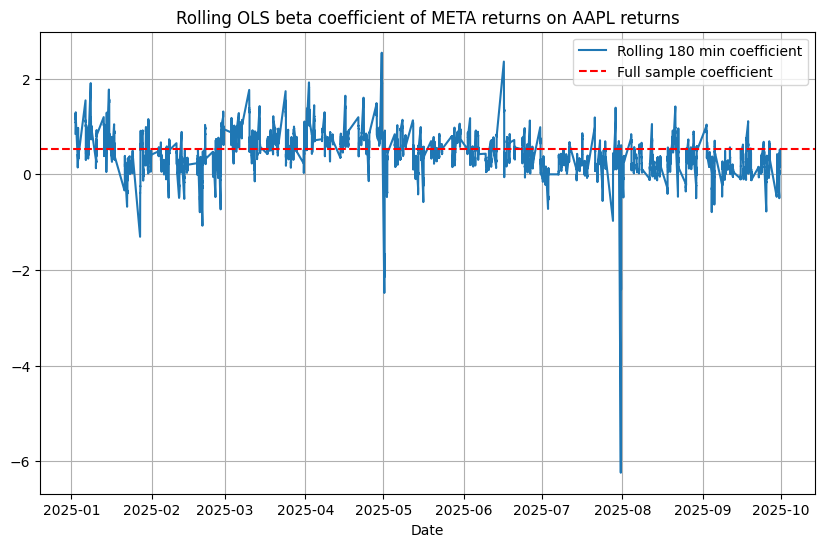

In [43]:
# lets plot rolling beta coefficient 
plt.figure(figsize=(10,6))
plt.plot(rolling_out.index, 
         rolling_out["r_AAPL"], 
         label = "Rolling 180 min coefficient")
# add a reference line for OLS beta
plt.axhline(y = beta_ols, 
            color = 'red', 
            linestyle = '--', 
            label = "Full sample coefficient")
plt.title("Rolling OLS beta coefficient of META returns on AAPL returns")
plt.xlabel("Date")
plt.legend()
plt.grid()


### Rolling Granger causality test

In [44]:
# lets write the function that would extract the p-values
# from the Granger causality test

def granger_pvalue(df: pd.DataFrame, # dataframe with data
                   col1: str, # caused variable
                   col2: str, # causing variable
                   maxlag: int) -> float: # maximum lag to test
    granger_test = grangercausalitytests(df[[col2, col1]], maxlag = [maxlag],
                                         verbose = False) # do NOT print the results
    p_value = granger_test[maxlag][0]['ssr_ftest'][1]
    return float(p_value)

In [45]:
# and apply it to our full dataset
p_value = granger_pvalue(dataUSA_AAPL_META, 
                         "close_AAPL", "close_META", 
                         maxlag = 10)
print("p-value from Granger causality test (AAPL causes META):", p_value)

p-value from Granger causality test (AAPL causes META): 0.00012815724271191746


In [47]:
# now we can calculate p-values on a rolling basis
# lets do it based on last 90 minutes every 15 minutes

# IMPORTANT
# Because .rolling().apply() only passes a single Series to the function, 
# we’ll use it on one column and reference to the second column is added 
# inside the lambda using its matching index.
# (lambda is simply an anonymous function without a name)

# what is more, rolling(...).apply must return a scalar
# (a single numeric value) so we run it once per p-value 
# and then concatenate the results

# helpers that call our function on a subset and return one p-value
# AAPL to META

# !! remember that we created a df_A_M dataframe earlier
# - it includes just the close prices of AAPL and META

_granger1 = lambda x: granger_pvalue(df_A_M.loc[x.index], 
                                     "close_AAPL", "close_META",
                                     maxlag = 10)
# META to AAPL
_granger2 = lambda x: granger_pvalue(df_A_M.loc[x.index], 
                                     "close_META", "close_AAPL",
                                     maxlag = 10)

granger_pvalues_AAPL_to_META = df_A_M["close_AAPL"].rolling(window = 90, 
                                                            step = 15).apply(_granger1)
granger_pvalues_META_to_AAPL = df_A_M["close_META"].rolling(window = 90,
                                                            step = 15).apply(_granger2)

granger_pvalues = pd.concat([granger_pvalues_META_to_AAPL.rename("p_value_META_to_AAPL"),
                             granger_pvalues_AAPL_to_META.rename("p_value_AAPL_to_META")],
                             axis=1).dropna()
# BUT !!!!
# This approach is SLOW
# it would take 5-10 minutes to calculate it every minute
# on this dataset

granger_pvalues.head()


,p_value_META_to_AAPL,p_value_AAPL_to_META
timestamp,,
2025-01-02 11:02:00,0.356564,0.554665
2025-01-02 11:17:00,0.231754,0.241754
2025-01-02 11:32:00,0.190630,0.133473
2025-01-02 11:47:00,0.113637,0.237278
2025-01-02 12:02:00,0.128397,0.158050


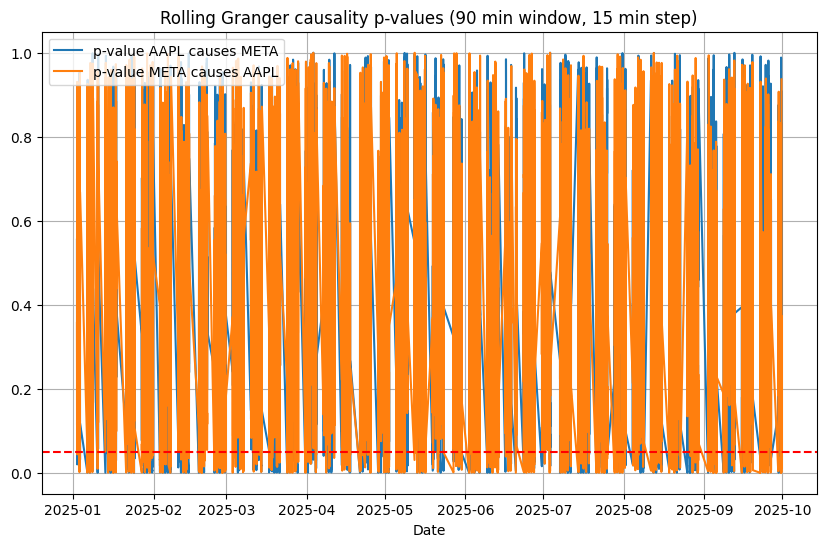

In [ ]:
# plot the rolling p-values
plt.figure(figsize=(10,6))
plt.plot(granger_pvalues.index, 
         granger_pvalues["p_value_AAPL_to_META"], 
         label="p-value AAPL causes META")
plt.plot(granger_pvalues.index, 
         granger_pvalues["p_value_META_to_AAPL"],
         label="p-value META causes AAPL")
plt.title("Rolling Granger causality p-values (90 min window, 15 min step)")
plt.xlabel("Date")
plt.legend()
plt.grid()
plt.axhline(y=0.05, color='red', linestyle='--', label="5% significance level")
plt.show()

In [49]:
# how often do we find causality
# (reject the null hypothesis) at 5% significance level?

rejections_META_to_AAPL = (granger_pvalues["p_value_META_to_AAPL"] < 0.05).sum()/len(granger_pvalues)
rejections_AAPL_to_META = (granger_pvalues["p_value_AAPL_to_META"] < 0.05).sum()/len(granger_pvalues)
print("Proportion of META causes AAPL:", rejections_META_to_AAPL)
print("Proportion of AAPL causes META:", rejections_AAPL_to_META)


Proportion of META causes AAPL: 0.15590062111801242
Proportion of AAPL causes META: 0.16107660455486542


In [50]:
# check with a contingency table how many times
# we have both rejections, none or only one-sided rejection

confusion_mat = confusion_matrix(
    granger_pvalues["p_value_META_to_AAPL"] < 0.05,
    granger_pvalues["p_value_AAPL_to_META"] < 0.05
)
# add labels of rows and columns
confusion_mat_df = pd.DataFrame(confusion_mat/np.sum(confusion_mat),
                                index=["META does NOT cause AAPL", "META causes AAPL"],
                                columns=["AAPL does NOT cause META", "AAPL causes META"])

print("Contingency table of results of Granger causality tests:")
print(confusion_mat_df)

Contingency table of results of Granger causality tests:
                          AAPL does NOT cause META  AAPL causes META
META does NOT cause AAPL                  0.728157          0.115942
META causes AAPL                          0.110766          0.045135


### Rolling cointegration tests

In [51]:
# helpers that call our previously defined functions 
# on a subset and return a p-value of the corresponding test
_adf = lambda x: eg_adf_pvalue(df_A_M.loc[x.index], 
                               "close_AAPL", "close_META")
_pp  = lambda x: eg_pp_pvalue(df_A_M.loc[x.index], 
                              "close_AAPL", "close_META")
_kpss= lambda x: eg_kpss_pvalue(df_A_M.loc[x.index], 
                                "close_AAPL", "close_META")

# we apply the test every 60 minutes on a 240 minute window
adf_p = df_A_M["close_META"].rolling(window = 240, 
                                     step = 60).apply(_adf)
pp_p  = df_A_M["close_META"].rolling(window = 240, 
                                     step = 60).apply(_pp)
kpss_p= df_A_M["close_META"].rolling(window = 240, 
                                     step = 60).apply(_kpss)

out = pd.concat({"adf_p": adf_p, "pp_p": pp_p, "kpss_p": kpss_p}, axis=1).dropna()


In [52]:
# lets see the results
out.head()

,adf_p,pp_p,kpss_p
timestamp,,,
2025-01-02 13:32:00,0.002595,0.044741,0.029158
2025-01-02 14:32:00,0.820029,0.621684,0.107061
2025-01-02 15:32:00,0.706093,0.620737,0.003113
2025-01-03 10:02:00,0.264178,0.419487,0.000547
2025-01-03 11:02:00,0.078720,0.134771,0.006858


In [53]:
# lets check how many times
# we would identify cointegration
# at 5% significance level

print("Share of times cointegration identified at 5% significance level:")
print("ADF test:", (out["adf_p"] < 0.05).sum()/out.size)
print("PP test:", (out["pp_p"] < 0.05).sum()/out.size)
# IMPORTANT - in KPSS H0 is about stationarity
print("KPSS test:", (out["kpss_p"] > 0.05).sum()/out.size)

Share of times cointegration identified at 5% significance level:
ADF test: 0.07109266943291839
PP test: 0.10816044260027663
KPSS test: 0.12669432918395573


# Exercises 3

Perform a similar analysis for **two other symbols** analyzed in Exercises 2

# Exercise 3.1

* Import the data set with the necessary variables saved in Exercises 2. 
* apply quantile regression for the median (quantile = 0.5) in a full sample
* apply rolling quantile regression for the median (quantile = 0.5) with a window of selected size. Do NOT do it every minute
* plot the rolling estimates of the slope coefficient with a reference line of the full-sample estimate

In [ ]:
# place for solution of Exercise 3.1

# Exercise 3.2

* test for Granger causality in both directions within a window of selected size. Do NOT do it every minute
* compute the proportion of causality findings at 5% significance level in both directions
* check with a contingency table how many times we have both rejections, none or only one-sided rejection

In [ ]:
# place for solution of Exercise 3.2

# Exercise 3.3

* test for cointegration (ADF, PP, KPSS) in the full sample - interpret the results
* test for cointegration (ADF, PP, KPSS) within a rolling window of selected size. Do NOT do it every minute
* plot the p-values of the tests within the rolling window
* check how often the cointegration is found at 5% significance level for each test

In [ ]:
# place for solution of Exercise 3.3

# Exercise 3.4 *

The Granger causality test is performed based on a linear regression model:

$$y_t = \alpha_0 + \sum_{i=1}^{p} \alpha_i y_{t-i} + \sum_{j=1}^{p} \beta_j x_{t-j} + \epsilon_t$$

The null hypothesis is that the coefficients $\beta_i$ are jointly equal to zero:

$$H_0: \beta_1 = \beta_2 = ... = \beta_p = 0$$

 If we reject the null hypothesis, we conclude that $x$ Granger-causes $y$.

It is tested with an F-test based on the sum of squared residuals from the unrestricted model (with lags $x$ included) and the restricted model (without lags of $x$).

$$F = \frac{(SSR_{R} - SSR_{UR})/p}{SSR_{U}/(n - 2p - 1)}$$

where $SSR_{R}$ is the sum of squared residuals from the restricted model (when the null hypothesis is true), $SSR_{U}$ is the sum of squared residuals from the unrestricted (full) model, $p$ is the number of lags (2p is the total number of regressors), and $n$ is the number of observations.

The results of the rollingOLS function include SSR values, so we can use them to calculate rolling Granger causality p-values more efficiently.

Check the code:
```python
rolling_results.ssr.tail()
```
and write a function that calculates rolling Granger causality p-values based on the SSR values from two rolling OLS results (one for the restricted model and one for the unrestricted model).@

In [ ]:
# place for solution of Exercise 3.4